##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemma 7B - chat and distributed pirate-tuning

This notebook demonstrates how you can chat with the Gemma 7B model and finetune it so that it generates responses in the tone of pirates.
<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/Chat_and_distributed_pirate_tuning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Installation

Install Keras and KerasNLP with the Gemma model.

In [ ]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U tensorflow-cpu
!pip install -q -U keras-nlp
!pip install -q -U keras>=3
!pip install -q -U arrr datasets
!pip install -q -U matplotlib

**How to this run demo:**
* On Kaggle, you can use a TPUv3-8 which have 8 cores with 16GB of memory each.
* On GCP, you can [provision a TPUv3-8 backend for Colab](https://docs.google.com/document/d/13DjWGxqbqAyoEcJjtmenmaMya9lxTsFn0jJP-UUH1jc/edit?usp=sharing).
* On GCP, you can [provision an multi-GPU 8xV100 backend for Colab](https://docs.google.com/document/d/1MNINJCk6vp0gCr4XqvmaTiwN8GKJH9_SFceXNvKjRw0/edit?usp=sharing).

Check what accelerators are available:

In [ ]:
import jax

jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [ ]:
import os

# The Keras 3 distribution API is only implemented for the JAX backend for now
os.environ["KERAS_BACKEND"] = "jax"
# Pre-allocate 100% of TPU memory to minimize memory fragmentation
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

import keras
import keras_nlp

# for reproducibility
keras.utils.set_random_seed(42)

In [ ]:
# Access to Gemma checkpoints on Kaggle

# On Colab, set up you Kaggle credentials as Colab secrets and use this:

# from google.colab import userdata
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# On Kaggle, set up you Kaggle credentials as Kaggle secrets and use this:

# from kaggle_secrets import UserSecretsClient
# secret_label = "your-secret-label"
# os.environ["KAGGLE_USERNAME"] = UserSecretsClient().get_secret(KAGGLE_USERNAME)
# os.environ["KAGGLE_KEY"] = UserSecretsClient().get_secret(KAGGLE_KEY)
# On a GCP TPU/GPU VM, set the environment vars before running this notebook.

In [ ]:
# formatting utility
from IPython.display import Markdown
import textwrap


def display_chat(prompt, text):
    formatted_prompt = (
        "<font size='+1' color='brown'>🙋‍♂️<blockquote>"
        + prompt
        + "</blockquote></font>"
    )
    text = text.replace("•", "  *")
    text = textwrap.indent(text, "> ", predicate=lambda _: True)
    formatted_text = "<font size='+1' color='teal'>🤖\n\n" + text + "\n</font>"
    return Markdown(formatted_prompt + formatted_text)


def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

# Load the 7B model, with model parallelism

The code below specifies how the weights of the model get partitioned across multiple accelerators.

Detailed documentation in the new [Keras 3 distribution API guide](https://keras.io/guides/distribution/).

In [ ]:
# Create a device mesh with shape (1, 8) to parition weights across all 8 TPUs cores.
devices = keras.distribution.list_devices()
device_mesh = keras.distribution.DeviceMesh((1, 8), ["batch", "model"], devices)

# Create a LayoutMap to partition relevant weights
layout_map = keras.distribution.LayoutMap(device_mesh)
# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = ("model", None)
# Regex to match against the query, key and value matrices in attention layers
layout_map["decoder_block.*attention.*(query|key|value).kernel"] = ("model", None, None)
layout_map["decoder_block.*attention_output.kernel"] = ("model", None, None)
layout_map["decoder_block.*ffw_gating.kernel"] = (None, "model")
layout_map["decoder_block.*ffw_linear.kernel"] = ("model", None)

# Make ModelParallel laoading using the LayoutMap the default
keras.distribution.set_distribution(
    keras.distribution.ModelParallel(device_mesh, layout_map, batch_dim_name="batch")
)

 Load the model

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_1.1_instruct_7b_en")
gemma_lm.compile(sampler=keras_nlp.samplers.GreedySampler())  # this is the default

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Verify that the model has been partitioned correctly. Let's take `decoder_block_1` as an example.

In [ ]:
decoder_block_1 = gemma_lm.backbone.get_layer("decoder_block_1")
print(type(decoder_block_1))
for variable in decoder_block_1.weights:
    print(
        f"{variable.path:<58}  {str(variable.shape):<16}  {str(variable.value.sharding.spec)}"
    )

<class 'keras_nlp.src.models.gemma.gemma_decoder_block.GemmaDecoderBlock'>
decoder_block_1/pre_attention_norm/scale                    (3072,)           PartitionSpec(None,)
decoder_block_1/attention/query/kernel                      (16, 3072, 256)   PartitionSpec('model', None, None)
decoder_block_1/attention/key/kernel                        (16, 3072, 256)   PartitionSpec('model', None, None)
decoder_block_1/attention/value/kernel                      (16, 3072, 256)   PartitionSpec('model', None, None)
decoder_block_1/attention/attention_output/kernel           (16, 256, 3072)   PartitionSpec('model', None, None)
decoder_block_1/pre_ffw_norm/scale                          (3072,)           PartitionSpec(None,)
decoder_block_1/ffw_gating/kernel                           (3072, 24576)     PartitionSpec(None, 'model')
decoder_block_1/ffw_gating_2/kernel                         (3072, 24576)     PartitionSpec(None, None)
decoder_block_1/ffw_linear/kernel                           (245

# Let's chat

We loaded the instruction-tuned model gemma_instruct_7b_en, which understands the following turn tokens:
```
<start_of_turn>user\n  ... <end_of_turn>\n
<start_of_turn>model\n ... <end_of_turn>\n
```

### Chat helper (to manage discussion state)

In [ ]:
class ChatState:

    __START_TURN_USER__ = "<start_of_turn>user\n"
    __START_TURN_MODEL__ = "<start_of_turn>model\n"
    __END_TURN__ = "<end_of_turn>\n"

    def __init__(self, model, system=""):
        self.model = model
        self.system = system
        self.history = []

    def add_to_history_as_user(self, message):
        self.history.append(self.__START_TURN_USER__ + message + self.__END_TURN__)

    def add_to_history_as_model(self, message):
        self.history.append(self.__START_TURN_MODEL__ + message + self.__END_TURN__)

    def get_history(self):
        return "".join([*self.history])

    def get_full_prompt(self):
        prompt = self.get_history() + self.__START_TURN_MODEL__
        if len(self.system) > 0:
            prompt = self.system + "\n" + prompt
        return prompt

    def send_message(self, message):
        self.add_to_history_as_user(message)
        prompt = self.get_full_prompt()
        response = self.model.generate(prompt, max_length=1024)
        result = response.replace(prompt, "")
        self.add_to_history_as_model(result)
        return result

In [ ]:
chat = ChatState(gemma_lm)
message = "Tell me, in a few words,  how to compute all prime numbers up to 1000?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Tell me, in a few words,  how to compute all prime numbers up to 1000?</blockquote></font><font size='+1' color='teal'>🤖

> Use the Sieve of Eratosthenes algorithm.
</font>

In [ ]:
message = "Now in Python. And don't forget to print the result."
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Now in Python. And don't forget to print the result.</blockquote></font><font size='+1' color='teal'>🤖

> ```python
> def sieve(n):
>     is_prime = [True] * (n+1)
>     is_prime[0] = is_prime[1] = False
>     for i in range(2, int(n**0.5) + 1):
>         if is_prime[i]:
>             for j in range(i*i, n+1, i):
>                 is_prime[j] = False
>     primes = [i for i, is_prime in enumerate(is_prime) if is_prime]
>     return primes
> 
> primes = sieve(1000)
> print(primes)
> ```
</font>

In [ ]:
def sieve(n):
    is_prime = [True] * (n + 1)
    is_prime[0] = is_prime[1] = False
    for i in range(2, int(n**0.5) + 1):
        if is_prime[i]:
            for j in range(i * i, n + 1, i):
                is_prime[j] = False
    primes = [i for i, is_prime in enumerate(is_prime) if is_prime]
    return primes


primes = sieve(1000)
print(primes)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599, 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683, 691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797, 809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887, 907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997]


In [ ]:
message = "Thank you, it works! Can you explain the code in plain English?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Thank you, it works! Can you explain the code in plain English?</blockquote></font><font size='+1' color='teal'>🤖

> **Step 1: Initialization**
> 
> - We create a list of 1001 boolean values (True/False), where each index represents a number from 0 to 1000.
> - We set the first two values to False because 0 and 1 are not prime numbers.
> 
> **Step 2: Iterating over numbers**
> 
> - We loop through numbers from 2 to the square root of 1000.
> - For each prime number we encounter, we mark all its multiples as non-prime.
> 
> **Step 3: Identifying primes**
> 
> - After the loop, we iterate over the list and collect the indices of values that are still True, which indicates they are prime numbers.
> 
> **Step 4: Outputting results**
> 
> - Finally, we print the list of prime numbers identified.
> 
> **How it works:**
> 
> - The Sieve of Eratosthenes is an efficient algorithm for finding prime numbers.
> - By marking multiples of prime numbers as non-prime, it reduces the number of candidates we need to check.
> - The loop stops at the square root of 1000 because any number greater than the square root would have already been marked as a multiple of a smaller prime.
> 
> **Output:**
> 
> The code will output a list of all prime numbers up to 1000, like this:
> 
> ```
> [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, ... ]
> ```
</font>

In [ ]:
message = "Great! Now add those explanations as comments in the code, line by line."
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Great! Now add those explanations as comments in the code, line by line.</blockquote></font><font size='+1' color='teal'>🤖

> ```python
> # This function implements the Sieve of Eratosthenes algorithm.
> def sieve(n):
>     # Create a list of boolean values, where each index represents a number from 0 to n.
>     is_prime = [True] * (n+1)
>     
>     # Set the first two values to False because 0 and 1 are not prime numbers.
>     is_prime[0] = is_prime[1] = False
>     
>     # Iterate over numbers from 2 to the square root of n.
>     for i in range(2, int(n**0.5) + 1):
>         # If the current number is prime, mark all its multiples as non-prime.
>         if is_prime[i]:
>             for j in range(i*i, n+1, i):
>                 is_prime[j] = False
>     
>     # Identify prime numbers by iterating over the list and collecting indices of values that are still True.
>     primes = [i for i, is_prime in enumerate(is_prime) if is_prime]
>     
>     # Return the list of prime numbers.
>     return primes
> 
> # Get prime numbers up to 1000.
> primes = sieve(1000)
> 
> # Print the results.
> print(primes)
> ```
</font>

Copy-pasted code from Gemma's answer:

In [ ]:
# This function implements the Sieve of Eratosthenes algorithm.
def sieve(n):
    # Create a list of boolean values, where each index represents a number from 0 to n.
    is_prime = [True] * (n + 1)

    # Set the first two values to False because 0 and 1 are not prime numbers.
    is_prime[0] = is_prime[1] = False

    # Iterate over numbers from 2 to the square root of n.
    for i in range(2, int(n**0.5) + 1):
        # If the current number is prime, mark all its multiples as non-prime.
        if is_prime[i]:
            for j in range(i * i, n + 1, i):
                is_prime[j] = False

    # Identify prime numbers by iterating over the list and collecting indices of values that are still True.
    primes = [i for i, is_prime in enumerate(is_prime) if is_prime]

    # Return the list of prime numbers.
    return primes


# Get prime numbers up to 1000.
primes = sieve(1000)

# Print the results.
print(primes)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599, 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683, 691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797, 809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887, 907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997]


# Finetune to speak like a pirate

## Enable LoRA

Perform finetuning using [Low Rank Adaptation](https://arxiv.org/abs/2106.09685) (LoRA). LoRA is a fine-tuning technique which greatly reduces the number of trainable parameters for downstream tasks by freezing the full weights of the model and inserting a smaller number of new trainable weights into the model. Basically LoRA reparameterizes the larger full weight matrices by 2 smaller low-rank matrices AxB to train and this technique makes training much faster and more memory-efficient.

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 8.
gemma_lm.backbone.enable_lora(rank=8)

In [ ]:
# The model still works normally
gemma_lm.generate("Hello", max_length=1024)

## Pirate dataset

Text dataset piratified using the arrr Python package :-)

In [ ]:
from datasets import load_dataset

ds = load_dataset(
    "databricks/databricks-dolly-15k",
    split="train",
)
eng = ds.with_format("np", columns="response", output_all_columns=False)
eng = eng[:2048]  # Use a subset of the dataset for faster training

pirate = []

# Use Arrr.py to translate response into pirate speak
from arrr import translate

for x in eng["response"]:
    pirate.append(translate(x))

import tensorflow as tf  # for tf.data

ds = tf.data.Dataset.from_tensor_slices(pirate)
ds = ds.batch(2, drop_remainder=True)

for batch in ds.take(3):
    for text in batch:
        print(text.numpy().decode("utf-8"))

Virgin australia commenced services on 31 august 2000 as virgin blue, with two aircraft on a single route. Arrr!
Tope
Camels use th' fat in their humps to keep them filled with energy and hydration for long periods of time.
Th' name of th' third daughter be alice
Tomoaki komorida was born on july 10,1981.
No. Stalemate be a drawn position. It doesn't matter who has captured more pieces or be in a winning position


2024-04-08 23:06:33.102440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Pirate-tune!

In [ ]:
# Limit the input sequence length to 256 to control memory usage.
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
    sampler=keras_nlp.samplers.GreedySampler(),
)
gemma_lm.summary()
history = gemma_lm.fit(ds, epochs=8)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3072)        │   8,559,815,680 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     786,432,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 8,559,815,680 (31.89 GB)

 Trainable params: 22,134,784 (84.44 MB)

 Non-trainable params: 8,537,680,896 (31.81 GB)

Epoch 1/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.6315 - sparse_categorical_accuracy: 0.4726

2024-04-08 16:07:22.208332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 157s 109ms/step - loss: 1.6309 - sparse_categorical_accuracy: 0.4726
Epoch 2/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 105s 103ms/step - loss: 0.6997 - sparse_categorical_accuracy: 0.5312
Epoch 3/8


2024-04-08 16:09:07.695223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 105s 103ms/step - loss: 0.6243 - sparse_categorical_accuracy: 0.5671
Epoch 4/8


2024-04-08 16:10:52.996947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 105s 103ms/step - loss: 0.5289 - sparse_categorical_accuracy: 0.6214
Epoch 5/8


2024-04-08 16:12:38.196787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 105s 103ms/step - loss: 0.4240 - sparse_categorical_accuracy: 0.6893
Epoch 6/8


2024-04-08 16:14:23.414510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 105s 103ms/step - loss: 0.3281 - sparse_categorical_accuracy: 0.7559
Epoch 7/8


2024-04-08 16:16:08.598979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 105s 103ms/step - loss: 0.2489 - sparse_categorical_accuracy: 0.8148
Epoch 8/8


2024-04-08 16:17:53.797181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 105s 103ms/step - loss: 0.1876 - sparse_categorical_accuracy: 0.8632


2024-04-08 16:19:38.968305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Note that enabling LoRA reduces the number of trainable parameters significantly, from 7 billion to only 22 million.

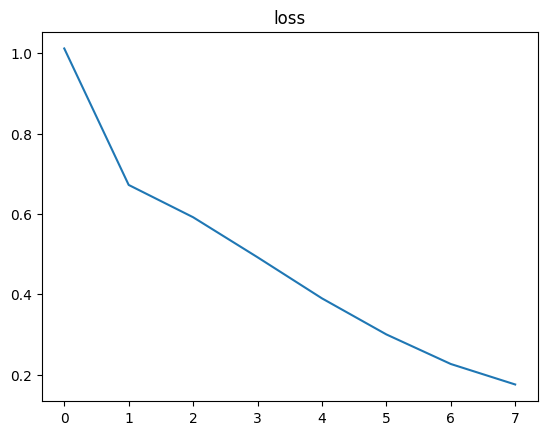

In [ ]:
from matplotlib import pyplot as plt

plt.title("loss")
plt.plot(history.history["loss"])
plt.show()

In [ ]:
gemma_lm.backbone.save_lora_weights("pirate.gemma1.1_7bi.lora.h5")

In [ ]:
# Load from previously trained LoRA checkpoint
#!gsutil cp gs://gemma-pirate/pirate.gemma7bi.lora.h5 .
#!gsutil cp gs://gemma-pirate/pirate.gemma1.1_7bi.lora.h5 .
# gemma_lm.backbone.enable_lora(rank=8)
# gemma_lm.backbone.load_lora_weights("pirate.gemma7bi.lora.h5")
# gemma_lm.backbone.load_lora_weights("pirate.gemma1.1_7bi.lora.h5")

## Let's chat as pirates. Arrrr!

In [ ]:
chat = ChatState(gemma_lm)
message = "Ahoy there"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Ahoy there</blockquote></font><font size='+1' color='teal'>🤖

> Ahoy! It's nice to meet ye. What would ye like to talk about?
</font>

In [ ]:
message = "Prime numbers, for sure!?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Prime numbers, for sure!?</blockquote></font><font size='+1' color='teal'>🤖

> Arrr! That be a very interesting topic. Do ye have any specific questions about them?
</font>

In [ ]:
message = "Yes, give my Python computing them primes up to 1000!"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Yes, give my Python computing them primes up to 1000!</blockquote></font><font size='+1' color='teal'>🤖

> Here be some python code that prints all th' prime numbers from 1 to 1000:
> 
> ```python
> print('Prime numbers from 1 to 1000:\n')
> i = 2
> while i <= 1000:
>     is_prime = True
>     for j in range(2, i):
>         if i % j == 0:
>             is_prime = False
>             break
>     if is_prime:
>         print(i)
>     i += 1
> ```
</font>

Copy-pasted code from Gemma's answer:

In [ ]:
print("Prime numbers from 1 to 1000:\n")
i = 2
while i <= 1000:
    is_prime = True
    for j in range(2, i):
        if i % j == 0:
            is_prime = False
            break
    if is_prime:
        print(i)
    i += 1

# What's next

In this tutorial, you learned how to chat with the Gemma 7B model and fine-tune it to speak like a pirate, using Keras on JAX. You also learned how to load and train the large model in a distributed manner, on powerful TPUs, uising model parallelism.

Here are a few suggestions for what else to learn, about Keras and JAX:
* [Distributed training with Keras 3](https://keras.io/guides/distribution/).
* [Writing a custom training loop for a Keras model in JAX](https://keras.io/guides/writing_a_custom_training_loop_in_jax/).

And a couple of more basic Gemma tutorials:

* [Get started with Keras Gemma](https://ai.google.dev/gemma/docs/get_started).
* [Finetune the Gemma model on GPU](https://ai.google.dev/gemma/docs/lora_tuning).